In [1]:
!pip install "numpy<2" --force-reinstall


DEPRECATION: Loading egg at c:\program files\python311\lib\site-packages\vboxapi-1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pyjpegls 1.5.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
pylibjpeg-libjpeg 2.3.0 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
pylibjpeg-openjpeg 2.5.0 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
qiskit-ibmq-provider 0.20.2 requires numpy<1.24, but you have numpy 1.26.4 which is incompatible.
streamlit 1.36.0 requires packag

Defaulting to user installation because normal site-packages is not writeable
  Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-win_amd64.whl (15.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4


In [2]:
import os
import json
import random
from collections import defaultdict
import numpy as np
from PIL import Image, ImageDraw

from extract_sqlite_annotations import load_annotations
from read_dicom_wsi import TileWSI


In [3]:
DB_PATH = r"D:\Digital_Pathology_Edge\Mitosis_Detection\data\raw\train\MITOS_WSI_CCMCT_ODAEL_train_dcm.sqlite"
RAW_ROOT = r"D:\Digital_Pathology_Edge\Mitosis_Detection\data\raw"
PATCH_ROOT = r"D:\Digital_Pathology_Edge\Mitosis_Detection\data\patches"
YOLO_ROOT = r"D:\Digital_Pathology_Edge\Mitosis_Detection\data\yolo"




In [4]:
from patch_extraction import extract_train_val
extract_train_val(DB_PATH, RAW_ROOT, PATCH_ROOT)


Extracting TRAIN...
Failed to load D:\Digital_Pathology_Edge\Mitosis_Detection\data\raw\train\1018715d369dd0df2fc0.dcm: [Errno 22] Invalid argument
Extracting VAL...


In [5]:
len(os.listdir(os.path.join(PATCH_ROOT, "train")))

37094

In [6]:
len(os.listdir(os.path.join(PATCH_ROOT, "val")))

10142

In [9]:
import os
import json
import random
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.patches as patches


In [8]:
def visualize_random_patches(patch_dir, n=5):
    pngs = [f for f in os.listdir(patch_dir) if f.endswith(".png")]
    samples = random.sample(pngs, min(n, len(pngs)))

    for fname in samples:
        img_path = os.path.join(patch_dir, fname)
        json_path = img_path.replace(".png", ".json")

        if not os.path.exists(json_path):
            continue

        img = Image.open(img_path)
        with open(json_path) as f:
            annos = json.load(f)

        fig, ax = plt.subplots(1, figsize=(6, 6))
        ax.imshow(img)

        for a in annos:
            x, y, w, h = a["bbox"]

            rect = patches.Rectangle(
                (x, y),
                w,
                h,
                linewidth=2,
                edgecolor="red",
                facecolor="none"
            )
            ax.add_patch(rect)

            ax.text(
                x, y - 3,
                f"class {a['class_id']}",
                color="yellow",
                fontsize=9,
                backgroundcolor="black"
            )

        ax.set_title(fname)
        ax.axis("off")
        plt.show()


In [10]:
PATCH_DIR = r"D:\Digital_Pathology_Edge\Mitosis_Detection\data\patches\train"


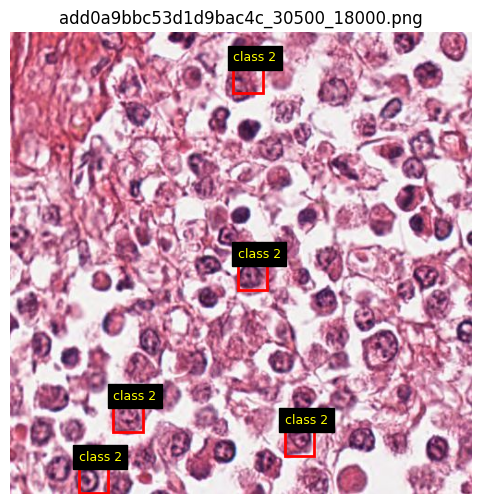

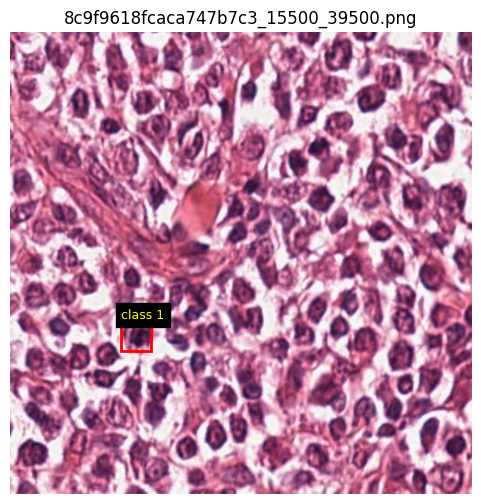

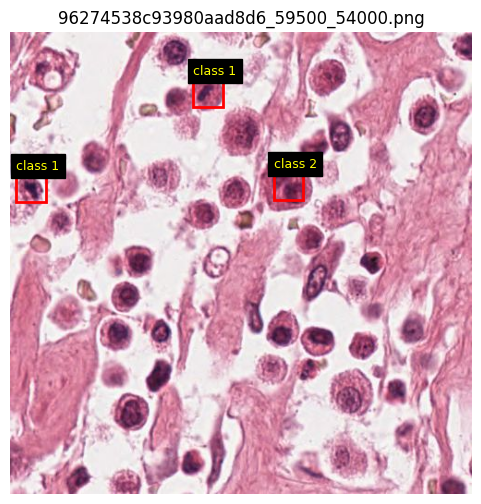

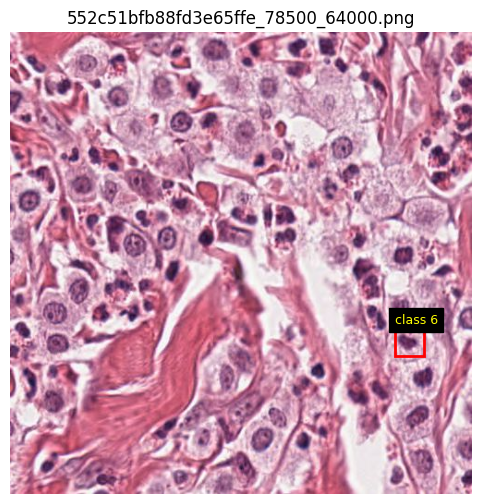

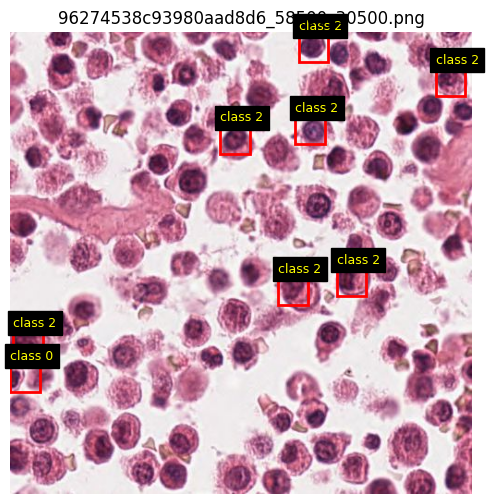

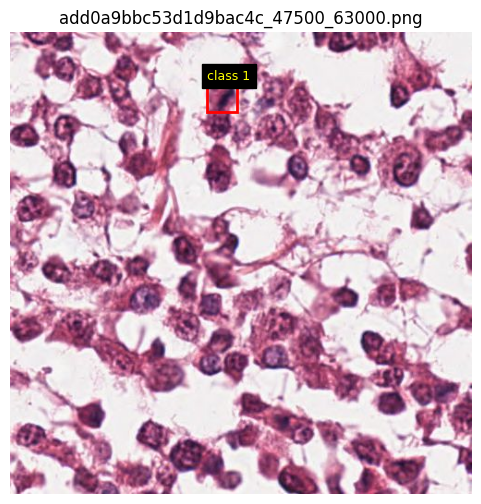

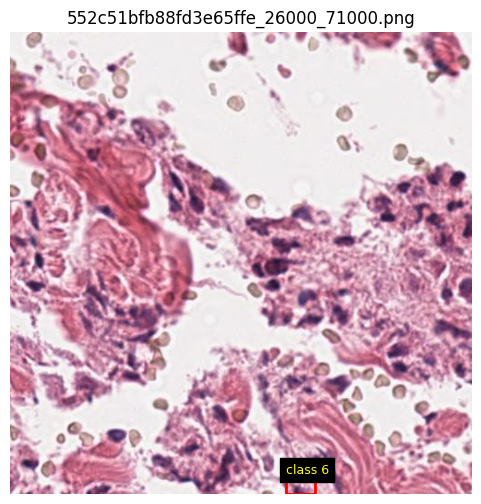

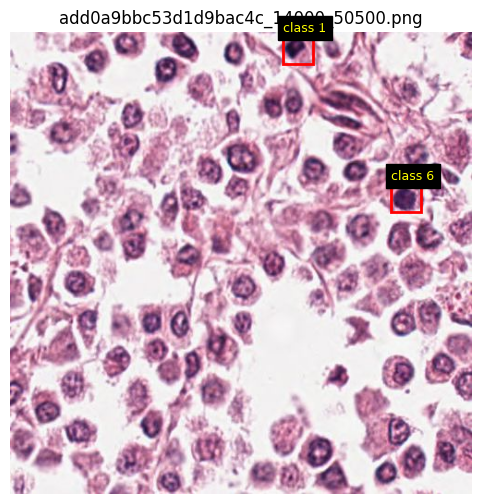

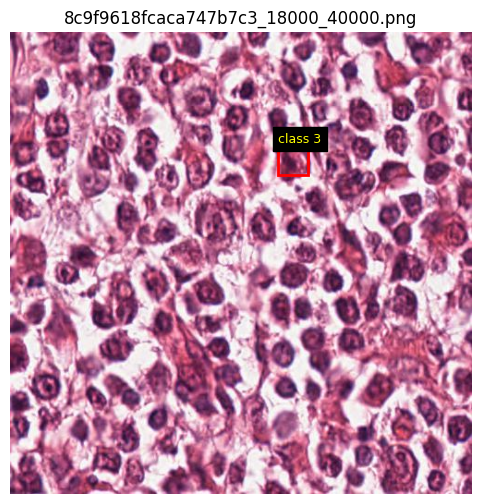

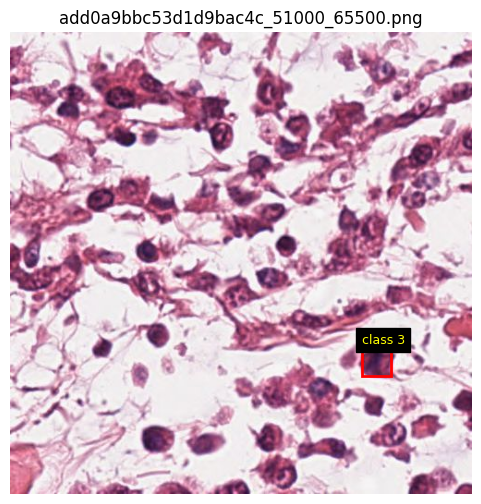

In [12]:
visualize_random_patches(PATCH_DIR, n=10)


In [ ]:
from coco_converter import build_coco
build_coco(f"{PATCH_ROOT}/train", f"{PATCH_ROOT}/train.json")
build_coco(f"{PATCH_ROOT}/val",   f"{PATCH_ROOT}/val.json")


In [3]:
import torch
torch.cuda.is_available()

True

In [4]:
print("Number of GPUs:", torch.cuda.device_count())

for i in range(torch.cuda.device_count()):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")

Number of GPUs: 1
GPU 0: Tesla T4


In [10]:
from ultralytics import YOLO

data_yaml = "D:/Digital_Pathology_Edge/Mitosis_Detection/data/yolo/dataset.yaml"

# Choose model
# 'yolov8n.pt' = nano (fastest, lightweight)
# 'yolov8s.pt' = small
# 'yolov8m.pt' = medium
# 'yolov8l.pt' = large
# 'yolov8x.pt' = extra large (slow, most accurate)
model = YOLO("yolov8n.pt")  # start from pretrained nano

# Train
model.train(
    data=data_yaml,
    imgsz=500,       # same as your patch size
    epochs=50,       # adjust based on GPU/time
    batch=16,        # adjust based on your GPU memory
    lr0=0.01,        # initial learning rate
    name="mitosis_detection",
    workers=8,       # number of CPU threads
    device=0         # GPU id, use 'cpu' for CPU training
)


Ultralytics 8.3.236 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=D:/Digital_Pathology_Edge/Mitosis_Detection/data/yolo/dataset.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=500, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=mitosis_detection4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, p

RuntimeError: Dataset 'D://Digital_Pathology_Edge/Mitosis_Detection/data/yolo/dataset.yaml' error ❌ 'D:/Digital_Pathology_Edge/Mitosis_Detection/data/yolo/dataset.yaml' does not exist

In [6]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.0 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 117.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.6 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.6 which is incompatible.
